In [1]:
from matplotlib import pyplot as plt
import numpy as np
import sklearn
import cv2
import math
from random import randint

In [2]:
img1 = cv2.imread("computers_left.png")
img2 = cv2.imread("computers_right.png")
img3 = cv2.imread("daft_punk_left.jpg")
img4 = cv2.imread("daft_punk_right.jpg")

In [3]:
def DetectAndCompute(img):
    my_SIFT_instance = cv2.SIFT_create()
#     img_grey = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    kps, des = my_SIFT_instance.detectAndCompute(img, None)
    matchimg = cv2.drawKeypoints(img, kps, None) #draw key points circle
    
    return matchimg,des,kps

In [4]:
img1_gray = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
matching1, des1, kps1 = DetectAndCompute(img1_gray)
matching2, des2, kps2 = DetectAndCompute(img2_gray)
img3_gray = cv2.cvtColor(img3,cv2.COLOR_BGR2GRAY)
img4_gray = cv2.cvtColor(img4,cv2.COLOR_BGR2GRAY)
matching3, des3, kps3 = DetectAndCompute(img3_gray)
matching4, des4, kps4 = DetectAndCompute(img4_gray)

In [5]:
def MatchDrawUpdate(des1, des2, kps1, kps2, img1, img2):
    matches = cv2.FlannBasedMatcher().knnMatch(des1, des2, k=2)
    good = []
    dis = []
    ptsLeft = []
    ptsRight = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append([m])
            dis.append(m.distance)
            ptsLeft.append(kps1[m.queryIdx].pt)
            ptsRight.append(kps2[m.trainIdx].pt)
    img = np.zeros((img1.shape[0],img1.shape[1]), dtype=np.uint8)
#     img_out = cv2.drawMatchesKnn(img1, kps1, img2, kps2, good, None) #result image after matching keypoints
   
    return ptsLeft, ptsRight

In [6]:
left_kps, right_kps = MatchDrawUpdate(des1, des2, kps1, kps2, img1_gray, img2_gray)
left_kps2, right_kps2 = MatchDrawUpdate(des3, des4, kps3, kps4, img3_gray, img4_gray)

In [7]:
def drawlines(img1, img2, lines, pts1, pts2):    

    r, c, l = img1.shape     
    for r, pt1, pt2 in zip(lines, pts1, pts2):
          
        color = tuple(np.random.randint(0, 255, 3).tolist())
          
        x0, y0 = map(int, [0, -r[2] / r[1] ])
        x1, y1 = map(int, [c, -(r[2] + r[0] * c) / r[1] ])
          
        img1 = cv2.line(img1,(x0, y0), (x1, y1), color, 1)
        img1 = cv2.circle(img1,tuple(pt1), 5, color, -1)
    return img1

In [8]:
def EpipolarLinesDraw(left_kps, right_kps, img1, img2):
    ptsLeft = np.int32(left_kps)
    ptsRight = np.int32(right_kps)
    F, mask = cv2.findFundamentalMat(ptsLeft, ptsRight, cv2.FM_LMEDS)
    ptsLeft = ptsLeft[mask.ravel() == 1]
    ptsRight = ptsRight[mask.ravel() == 1]
    linesLeft = cv2.computeCorrespondEpilines(ptsRight.reshape(-1, 1, 2),2,F)
    linesLeft = linesLeft.reshape(-1, 3)
    img5 = drawlines(img1, img2, linesLeft, ptsLeft, ptsRight)

    linesRight = cv2.computeCorrespondEpilines(ptsLeft.reshape(-1, 1, 2),1, F)
    linesRight = linesRight.reshape(-1, 3)  
    img7 = drawlines(img2, img1, linesRight, ptsRight,ptsLeft)

    plt.subplot(121), plt.imshow(cv2.cvtColor(img5,cv2.COLOR_BGR2RGB))
    plt.subplot(122), plt.imshow(cv2.cvtColor(img7,cv2.COLOR_BGR2RGB))
    plt.show()  

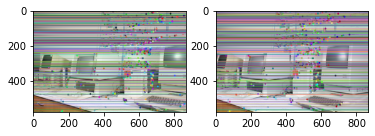

In [9]:
EpipolarLinesDraw(left_kps, right_kps, img1, img2)

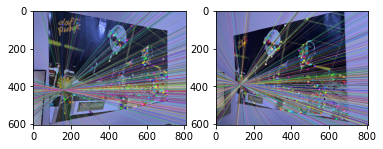

In [10]:
EpipolarLinesDraw(left_kps2, right_kps2, img3, img4)

In [11]:
def DrawOneLine(event, x, y, flag, param):
    if event == cv2.EVENT_LBUTTONUP:  
        cv2.destroyAllWindows()
        img1 = param[0]
        img2 = param[1]
        point = [x,y]
        matching1, des1, kps1 = DetectAndCompute(img1)
        matching2, des2, kps2 = DetectAndCompute(img2)
        Lpt, Rpt = MatchDrawUpdate(des1, des2, kps1, kps2, img1, img2)
        Lpt = np.int32(Lpt)
        Rpt = np.int32(Rpt)
        mask = cv2.findFundamentalMat(Lpt, Rpt, cv2.FM_LMEDS)
        Lpt[-1] = point
        line = [cv2.computeCorrespondEpilines(Lpt, 1, mask[0])[-1]]
        img1 = cv2.circle(img1, tuple(point), 5, (0,255,0), -1)
        col3 = img2.shape[1]
        img2 = img2.copy()
        for i, j in zip(line, Rpt):
            i = i[0]
            x1,y1 = [0, int(-i[2]/i[1])]
            x2,y2 = [col3, int(-(i[2]+i[0]*col3)/i[1])]
            img2 = cv2.line(img2, (x1,y1), (x2,y2), (0,255,0), thickness = 1)
        
        plt.figure(dpi=100)
        plt.subplot(1,2,1)
        plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
        plt.subplot(1,2,2)
        plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

In [12]:
def Display(img1, img2):
    while True:
        cv2.imshow("Image", img1)
        cv2.setMouseCallback("Image",DrawOneLine,[img1, img2])
        k = cv2.waitKey(1)
        if k == 27:
            break                                                 
    cv2.destroyAllWindows()

enter esc to display result image


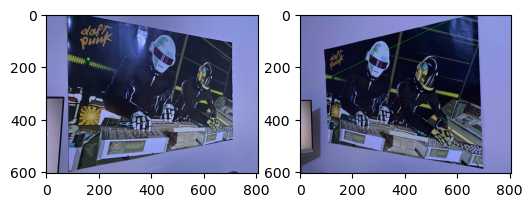

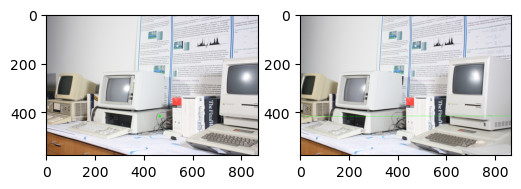

In [13]:
img1 = cv2.imread("computers_left.png")
img2 = cv2.imread("computers_right.png")
img3 = cv2.imread("daft_punk_left.jpg")
img4 = cv2.imread("daft_punk_right.jpg")
Display(img3, img4)
print("enter esc to display result image")
Display(img1, img2)